(ext_precision_tutorial)=

Computations in extended precision
==================================

As hinted in the [expression system tutorial](<./The expression system.ipynb>), heyoka.py supports computations not only in double precision, but also in extended precision. Specifically, heyoka.py currently supports:

- the 80-bit IEEE [extended-precision format](https://en.wikipedia.org/wiki/Extended_precision) (~21 decimal digits),
- the 128-bit IEEE [quadruple-precision format](https://en.wikipedia.org/wiki/Quadruple-precision_floating-point_format) (~36 decimal digits).

How these extended precision floating-point types can be accessed and used from Python varies depending on the platform. In particular:

- if you are using an Intel x86 processor and your C/C++ compiler implements ``long double`` as the 80-bit IEEE extended-precision format, then the 80-bit IEEE floating-point type is available as the NumPy {py:class}`~numpy.longdouble` type;
- if you are on a platform with support for the non-standard ``__float128`` type, then the 128-bit IEEE floating-point type is available as the ``heyoka.real128`` type;
- if you are on a platform where the C/C++ ``long double`` type is implemented as a quadruple-precision IEEE floating-point type (e.g., 64-bit Linux ARM), then the 128-bit IEEE floating-point type is available as the NumPy {py:class}`~numpy.longdouble` type.

In other words, extended precision computations in heyoka.py are supported via the NumPy {py:class}`~numpy.longdouble` type (which could be either an 80-bit or 128-bit floating-point type, depending on the platform) and the ``heyoka.real128`` type (which will always be a 128-bit floating-point type, if available).

Extended-precision (80-bit) example
-----------------------------------

For this first example, we will be assuming that {py:class}`~numpy.longdouble` implements the 80-bit extended-precision floating-point format. In order to verify that heyoka.py indeed is able to work in extended precision, we will be monitoring the evolution of the energy constant in a high-precision numerical integration of the simple pendulum.

Let us begin as usual with the definition of the dynamical equations:

In [1]:
import heyoka as hy

# Create the symbolic variables x and v.
x, v = hy.make_vars("x", "v")

# Define the dynamical equations.
sys = [(x, v), (v, -9.8 * hy.sin(x))]


# Define a small helper to compute the energy
# from the state vector.
def compute_energy(sv):
    from numpy import cos

    return (sv[1] * sv[1]) / 2 + sv.dtype.type(9.8) * (1 - cos(sv[0]))

Next, we are going to create an integrator object in extended precision:

In [2]:
import numpy as np

ta = hy.taylor_adaptive(
    sys,
    # Initial conditions in extended precision.
    np.array([-1, 0], dtype=np.longdouble),
    # Tolerance - also in extended precision.
    tol=np.longdouble(1e-20),
    # Specify that the integrator must operate
    # in extended precision.
    fp_type=np.longdouble,
)

In order to enable extended precision, we passed the ``fp_type=np.longdouble`` argument to the constructor, and we made sure that both the initial state vector ``[0.05, 0.025]`` and the tolerance value ``1e-20`` are specified in extended precision.

Next, we compute and store the initial energy of the system for later use:

In [3]:
# Compute the initial energy of the system.
orig_E = compute_energy(ta.state)

We proceed now with a numerical integration over a time grid, up to $t=300$:

In [4]:
# Create a time grid in extended precision.
t_grid = np.linspace(0, 300, 100, dtype=np.longdouble)
out = ta.propagate_grid(t_grid)[-1]

Note how the time grid was also created in extended precision.

We can now proceed with the computation and the visualisation of the energy error:

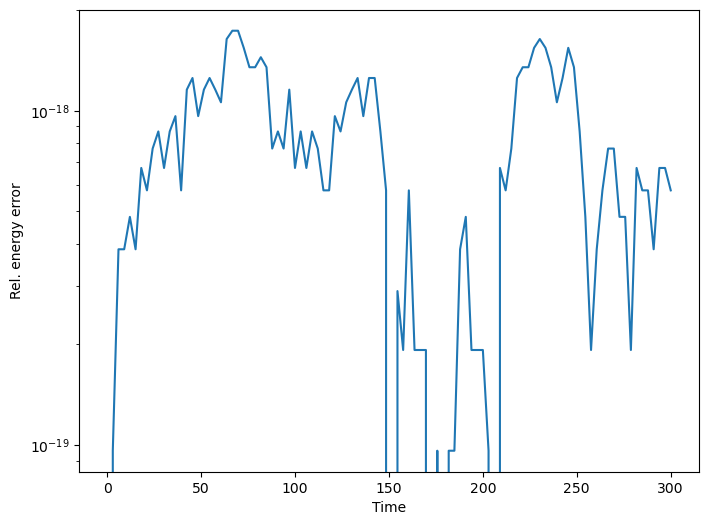

In [5]:
# Compute the relative energy error over the time grid.
E_err = abs((orig_E - compute_energy(out.transpose())) / orig_E)

# Plot the energy error.
from matplotlib.pylab import plt

fig = plt.figure(figsize=(8, 6))
plt.semilogy(t_grid, E_err)
plt.xlabel("Time")
plt.ylabel("Rel. energy error");

We can see indeed how the energy error is kept at around the epsilon of the extended-precision floating-point type ($\sim 10^{-19}$).

Quadruple-precision (128-bit) example
-------------------------------------

Switching to quadruple precision is just a matter of replacing {py:class}`~numpy.longdouble` with ``heyoka.real128``:

In [6]:
ta = hy.taylor_adaptive(
    sys,
    # Initial conditions in quadruple precision.
    np.array([-1, 0], dtype=hy.real128),
    # Tolerance - also in quadruple precision.
    tol=hy.real128(1e-35),
    # Specify that the integrator must operate
    # in quadruple precision.
    fp_type=hy.real128,
)

``heyoka.real128`` is a Python wrapper for the [``real128``](https://bluescarni.github.io/mppp/real128.html) C++ class from the mp++ library. In addition to being available as a scalar type, ``heyoka.real128`` can also be used as a ``dtype`` in NumPy, so that it is possible to create and manipulate NumPy arrays of ``heyoka.real128`` instances.

Like in the previous example, we can now proceed to monitor the energy conservation for the pendulum system:

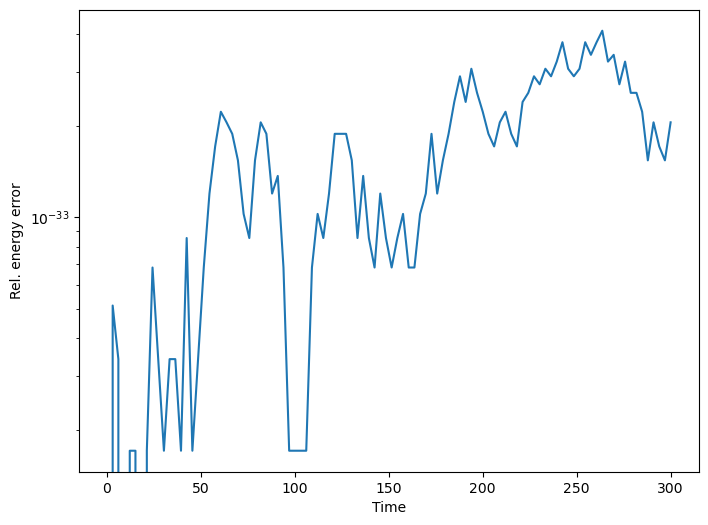

In [7]:
# Compute the initial energy of the system.
orig_E = compute_energy(ta.state)

# Create a time grid in quadruple precision.
t_grid = np.linspace(0, 300, 100, dtype=hy.real128)
out = ta.propagate_grid(t_grid)[-1]

# Compute the relative energy error over the time grid.
E_err = abs((orig_E - compute_energy(out.transpose())) / orig_E)

# Plot the energy error.
from matplotlib.pylab import plt

fig = plt.figure(figsize=(8, 6))
plt.semilogy(t_grid, E_err)
plt.xlabel("Time")
plt.ylabel("Rel. energy error");

We can see indeed how the energy error is kept at around the epsilon of the quadruple-precision floating-point type.

Other classes and functions
---------------------------

Besides the adaptive integrator, several other classes and functions in heyoka.py can be used in extended precision. The [event classes](<./Event detection.ipynb>), for instance, can be constructed in extended precision:

In [8]:
# Construct a terminal event in extended precision.
ev = hy.t_event(x, fp_type=np.longdouble, cooldown=np.longdouble(1e-8))

As with the adaptive integrator, in order to enable extended precision we must pass the ``fp_type`` keyword argument, and any numerical quantity passed to the constructor (such as the cooldown in this specific case) must also be created in extended precision.

Note that the precision of an event must match the precision of the integrator object in which the event is used, otherwise a runtime error will be raised during the construction of the integrator.

Caveats, limitations & issues
-----------------------------

### Initialising numbers in extended precision

A typical pitfall when working with extended precision numbers involves their initialisation. For instance, if you want to initialise a quadruple-precision approximation of the number $1.1$, you may be tempted to write:

In [9]:
hy.real128(1.1)

1.10000000000000008881784197001252323

As you can see however, doing so does not produce the best possible quadruple-precision approximation of $1.1$. The issue here is that the Python literal ``1.1`` is first interpreted as a double-precision value, and then widened to quadruple-precision in the conversion to ``hy.real128``.

The issue can be solved by initialising from string:

In [10]:
hy.real128("1.1")

1.10000000000000000000000000000000008

Similarly, if you need to construct an extended precision value from a fraction, it is better to construct the numerator and denominator separately, and then compute the quotient:

In [11]:
# Don't do this!
hy.real128(3.0 / 10.0)

0.299999999999999988897769753748434596

In [12]:
# Do this instead.
hy.real128(3) / hy.real128(10)

0.29999999999999999999999999999999999

### NumPy issues and limitations

Although it is possible to construct NumPy arrays in extended precision and to perform basic operations on them, there are limitations to what one can do with extended precision arrays.

To begin with, many NumPy facilities are not available at all in extended precision (e.g., random number generation, nontrivial linear algebra, etc.). In addition, there seem to be several small issues involving NumPy's casting and conversion primitives when using the ``heyoka.real128`` type, which typically result in runtime exceptions. It is unclear at this time whether these are genuine NumPy bugs or issues in the ``heyoka.real128`` wrapping code.

Despite these limitations, basic uses of extended precision arrays (such as slicing, indexing, arithmetic, special functions and explicit conversions to/from other types) are supported and working as intended.